# 02 — Weather Features

**Phase 2a: Feature Engineering**

## What you'll learn

- Why temperature, wind, and precipitation matter for electricity prices
- **Lag features** — using past values to predict the future
- **Rolling statistics** — smoothing noisy data with moving averages
- How to handle hourly weather data from Frost API

## Why weather drives electricity prices

Norway's electricity system is ~95% hydro power. Weather affects both **supply and demand**:

| Weather | Effect on demand | Effect on supply | Net price impact |
|---------|-----------------|-----------------|------------------|
| **Cold** | More heating needed | — | Price UP |
| **Wind** | — | More wind generation | Price DOWN |
| **Rain** | — | Fills reservoirs (future supply) | Price DOWN (gradual) |
| **Snow melt** | — | Spring floods fill reservoirs | Price DOWN (seasonal) |

In [1]:
import sys
from pathlib import Path

# Add project root to path so 'from src...' imports work
PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cached weather data for Bergen (NO_5)
from src.data.fetch_metro import fetch_zone_weather

weather = fetch_zone_weather("NO_5", "2020-01-01", "2026-02-22", cache=True)

print(f"Shape: {weather.shape}")
print(f"Columns: {list(weather.columns)}")
print(f"Date range: {weather.index.min()} to {weather.index.max()}")
print(f"\nFirst 5 rows:")
weather.head()

Shape: (53712, 3)
Columns: ['air_temperature', 'wind_speed', 'precipitation']
Date range: 2020-01-01 01:00:00+01:00 to 2026-02-22 00:00:00+01:00

First 5 rows:


,air_temperature,wind_speed,precipitation
timestamp,,,
2020-01-01 01:00:00+01:00,6.6,4.8,0.2
2020-01-01 02:00:00+01:00,6.8,6.1,0.0
2020-01-01 03:00:00+01:00,6.9,5.8,0.1
2020-01-01 04:00:00+01:00,6.9,4.3,0.0
2020-01-01 05:00:00+01:00,6.9,4.8,0.0


## Explore the raw weather data

Before engineering features, always **look at your data**. What are the ranges? Are there patterns? Outliers?

In [2]:
print("Basic statistics:")
print(weather.describe().round(2))
print(f"\nMissing values:")
print(weather.isna().sum())

Basic statistics:
       air_temperature  wind_speed  precipitation
count         53712.00    53712.00       53712.00
mean              8.79        3.44           0.28
std               6.37        2.31           0.84
min             -11.40        0.10          -0.40
25%               4.40        1.60           0.00
50%               8.70        3.00           0.00
75%              13.20        4.80           0.10
max              30.40       22.30          18.80

Missing values:
air_temperature    0
wind_speed         0
precipitation      0
dtype: int64


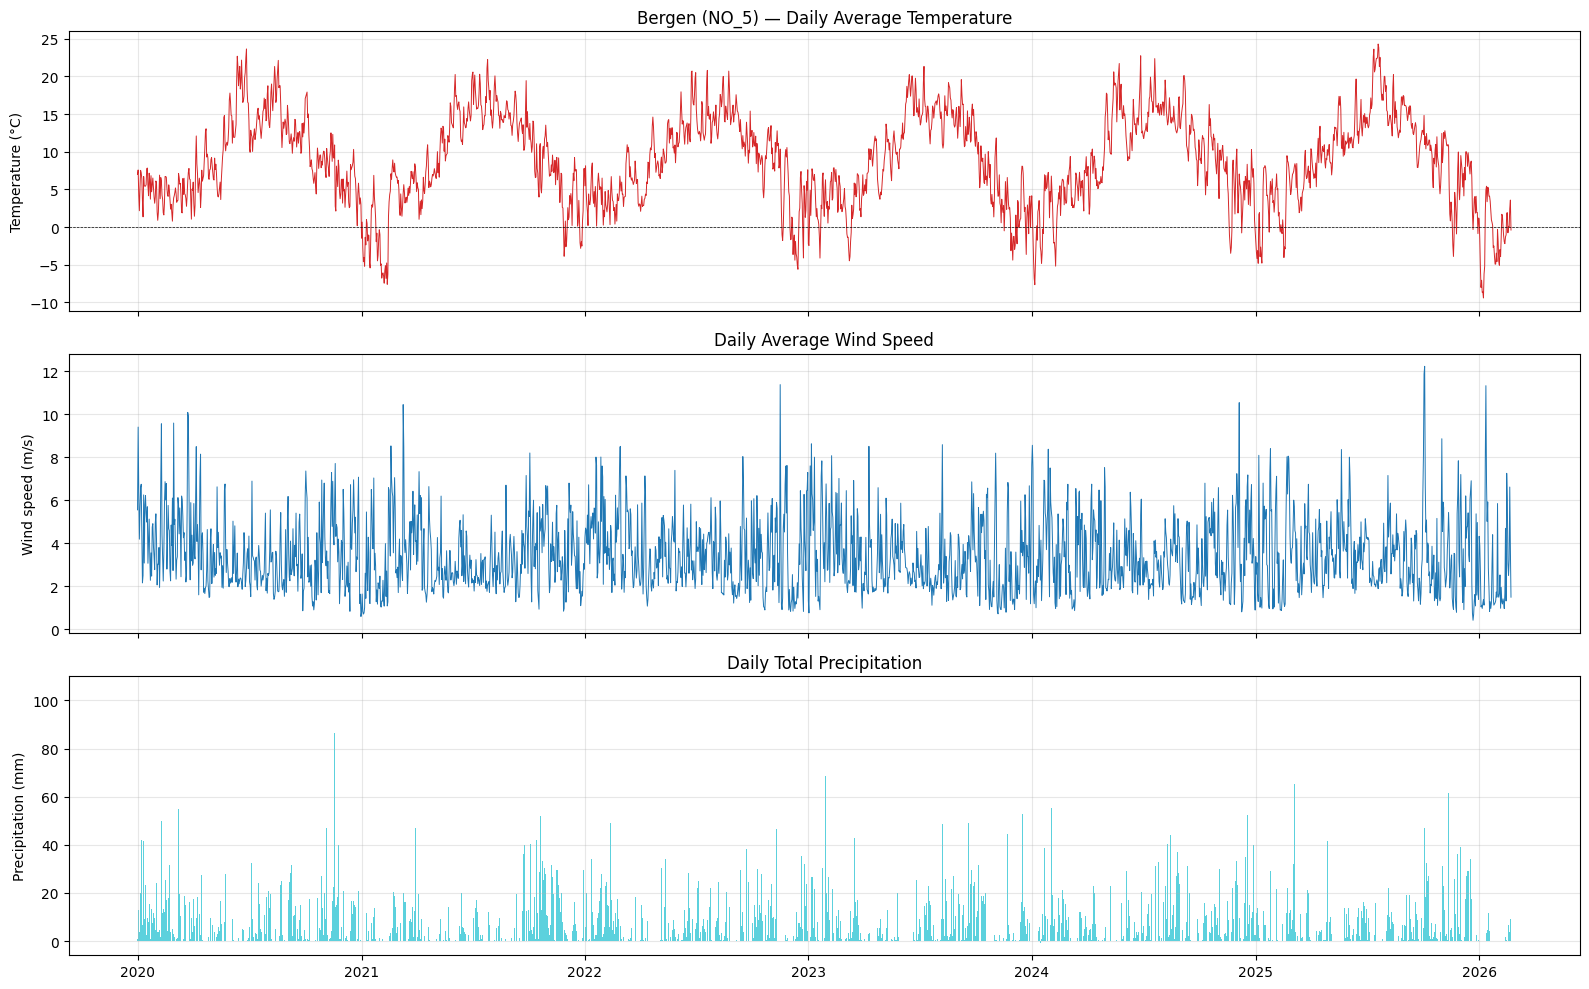

Notice the clear seasonal pattern in temperature.
Bergen is famous for rain — precipitation is very common year-round.


In [3]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Downsample to daily for readability
daily = weather.resample("D").mean()

ax = axes[0]
ax.plot(daily.index, daily["air_temperature"], color="tab:red", linewidth=0.7)
ax.axhline(y=0, color="black", linewidth=0.5, linestyle="--")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Bergen (NO_5) — Daily Average Temperature")
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(daily.index, daily["wind_speed"], color="tab:blue", linewidth=0.7)
ax.set_ylabel("Wind speed (m/s)")
ax.set_title("Daily Average Wind Speed")
ax.grid(True, alpha=0.3)

ax = axes[2]
daily_precip = weather["precipitation"].resample("D").sum()
ax.bar(daily_precip.index, daily_precip.values, width=1, color="tab:cyan", alpha=0.7)
ax.set_ylabel("Precipitation (mm)")
ax.set_title("Daily Total Precipitation")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice the clear seasonal pattern in temperature.")
print("Bergen is famous for rain — precipitation is very common year-round.")

## Concept: Lag Features

A **lag feature** takes a value from N hours ago and uses it as a feature for the current hour.

**Why?** Because the price at 3 PM today is influenced by what the temperature was yesterday at 3 PM. If yesterday was cold and expensive, today will likely be similar.

```
Hour    Temperature    temperature_lag_24h
Mon 08      -5°C           NaN  (no data 24h ago)
Mon 09      -4°C           NaN
...         ...            ...
Tue 08      -3°C          -5°C  (Mon 08's temperature)
Tue 09      -2°C          -4°C  (Mon 09's temperature)
```

The model can then compare: "Today is warmer than yesterday → less heating needed → price might drop."

In [4]:
# Create a lag feature: temperature 24 hours ago
weather["temperature_lag_24h"] = weather["air_temperature"].shift(24)

# Show how it works
print("Lag feature example (first 30 hours):")
print(weather[["air_temperature", "temperature_lag_24h"]].head(30))

print(f"\nNotice: first 24 rows have NaN for the lag (no data 24h before start).")
print(f"Missing lag values: {weather['temperature_lag_24h'].isna().sum()}")

Lag feature example (first 30 hours):
                           air_temperature  temperature_lag_24h
timestamp                                                      
2020-01-01 01:00:00+01:00              6.6                  NaN
2020-01-01 02:00:00+01:00              6.8                  NaN
2020-01-01 03:00:00+01:00              6.9                  NaN
2020-01-01 04:00:00+01:00              6.9                  NaN
2020-01-01 05:00:00+01:00              6.9                  NaN
2020-01-01 06:00:00+01:00              6.9                  NaN
2020-01-01 07:00:00+01:00              7.0                  NaN
2020-01-01 08:00:00+01:00              7.0                  NaN
2020-01-01 09:00:00+01:00              7.0                  NaN
2020-01-01 10:00:00+01:00              7.0                  NaN
2020-01-01 11:00:00+01:00              7.0                  NaN
2020-01-01 12:00:00+01:00              7.2                  NaN
2020-01-01 13:00:00+01:00              7.3                  NaN
20

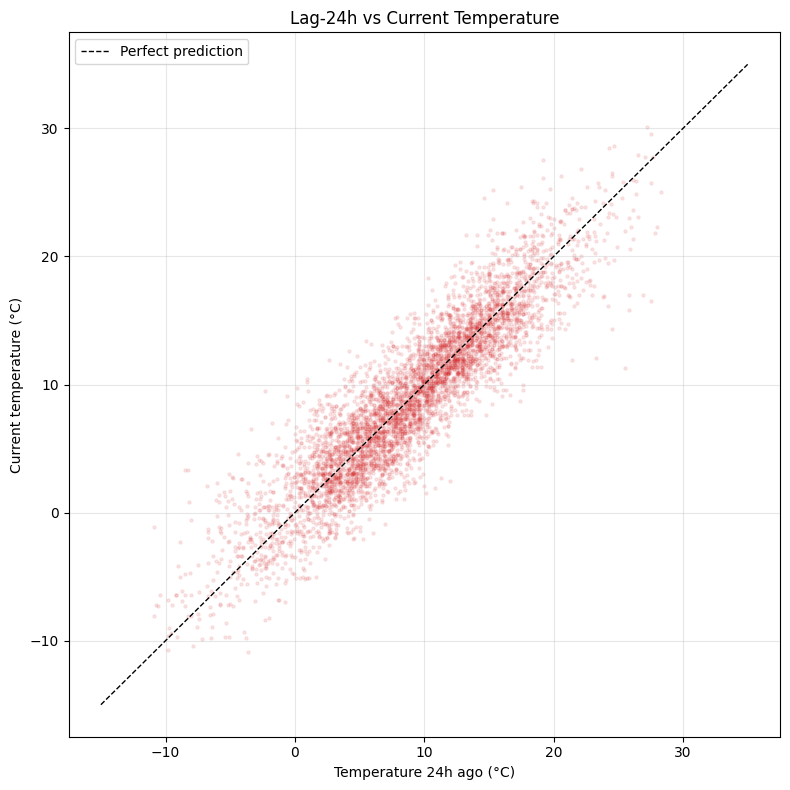

Correlation between current and 24h-ago temperature: 0.902
Very high! Yesterday's temperature is a strong predictor of today's.


In [5]:
# Visualize: how well does yesterday's temperature predict today's?
fig, ax = plt.subplots(figsize=(8, 8))

# Sample for speed
sample = weather.dropna().sample(5000, random_state=42)
ax.scatter(sample["temperature_lag_24h"], sample["air_temperature"],
           alpha=0.1, s=5, color="tab:red")
ax.plot([-15, 35], [-15, 35], "k--", linewidth=1, label="Perfect prediction")
ax.set_xlabel("Temperature 24h ago (°C)")
ax.set_ylabel("Current temperature (°C)")
ax.set_title("Lag-24h vs Current Temperature")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = weather["air_temperature"].corr(weather["temperature_lag_24h"])
print(f"Correlation between current and 24h-ago temperature: {corr:.3f}")
print("Very high! Yesterday's temperature is a strong predictor of today's.")

## Concept: Rolling Statistics

A **rolling mean** (moving average) smooths out noise and captures the **trend**.

```
Hour    Temp    rolling_24h_mean
00       2°C         2.0  (only 1 value so far)
01       3°C         2.5  (avg of 2, 3)
02       1°C         2.0  (avg of 2, 3, 1)
...     ...          ...
23       4°C         3.1  (avg of last 24 hours)
```

**Why useful?** A single hour's temperature can be noisy (brief wind gust, rain shower). The 24h average tells you "what's the general temperature regime right now?" — which is what drives heating demand.

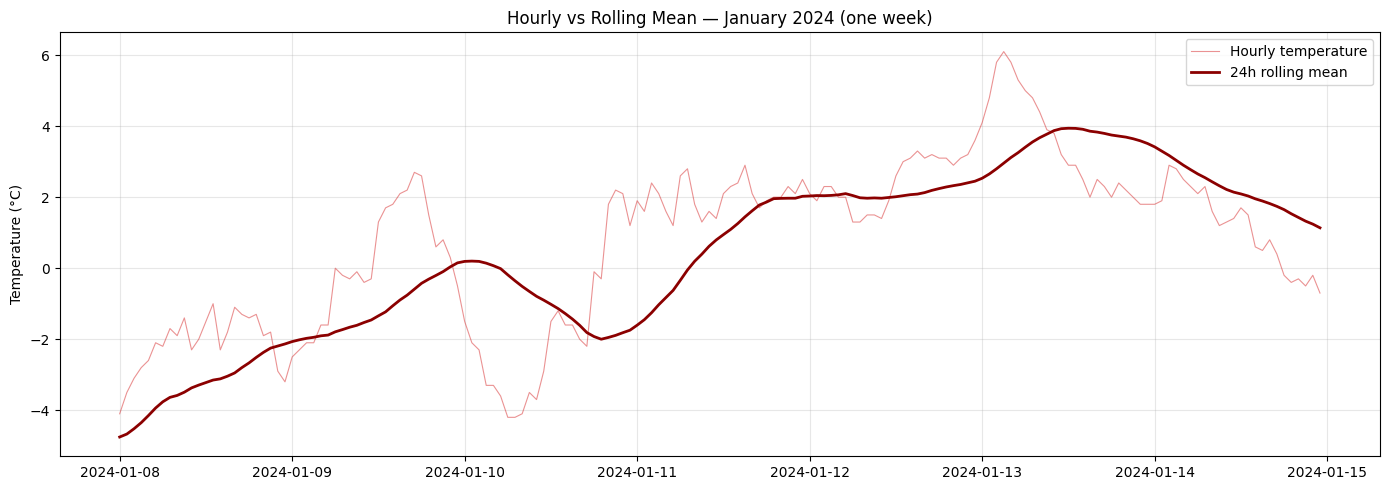

The rolling mean removes hourly fluctuations and shows the overall trend.
This is more useful for predicting price than any single hour's reading.


In [6]:
# Create a 24-hour rolling mean
weather["temperature_rolling_24h_mean"] = (
    weather["air_temperature"]
    .rolling(window=24, min_periods=1)
    .mean()
)

# Show the smoothing effect on a winter week
week = weather.loc["2024-01-08":"2024-01-14"]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(week.index, week["air_temperature"], color="tab:red", alpha=0.5,
        linewidth=0.8, label="Hourly temperature")
ax.plot(week.index, week["temperature_rolling_24h_mean"], color="darkred",
        linewidth=2, label="24h rolling mean")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Hourly vs Rolling Mean — January 2024 (one week)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("The rolling mean removes hourly fluctuations and shows the overall trend.")
print("This is more useful for predicting price than any single hour's reading.")

## Seasonal temperature patterns

Let's look at how temperature varies by month and hour — this directly affects electricity demand.

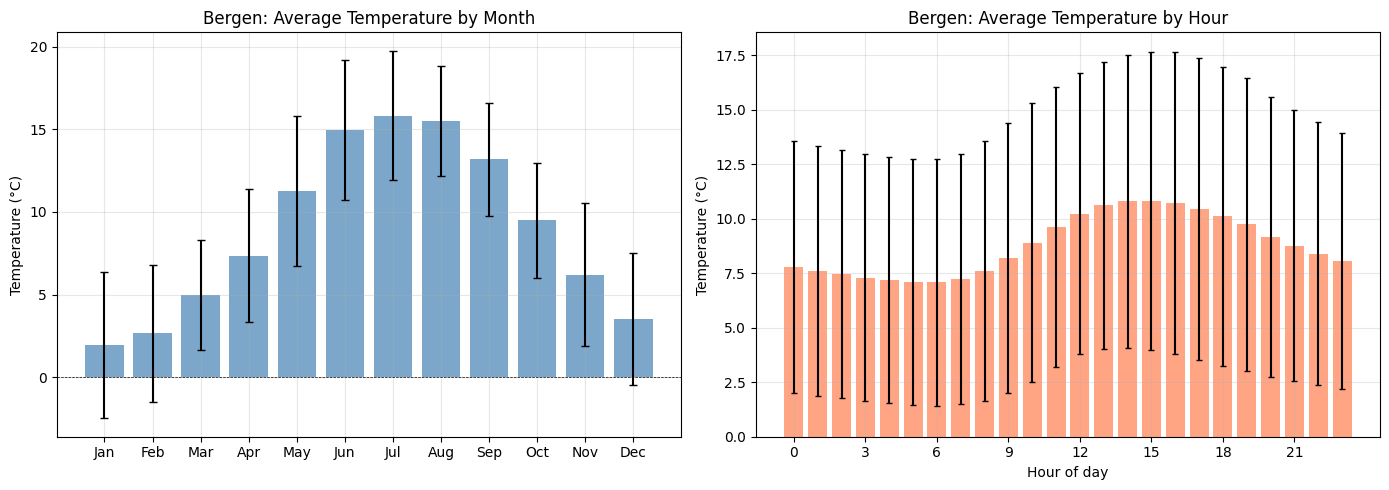

Winter (Dec–Feb): ~2–4°C → HIGH heating demand → HIGH prices
Summer (Jun–Aug): ~14–16°C → LOW heating demand → LOW prices
Daily cycle: warmest around 14:00, coldest around 05:00


In [7]:
# Average temperature by month
weather["month"] = weather.index.month
weather["hour"] = weather.index.hour

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By month
ax = axes[0]
monthly = weather.groupby("month")["air_temperature"].agg(["mean", "std"])
ax.bar(monthly.index, monthly["mean"], yerr=monthly["std"], capsize=3,
       color="steelblue", alpha=0.7)
ax.axhline(y=0, color="black", linewidth=0.5, linestyle="--")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun",
                     "Jul","Aug","Sep","Oct","Nov","Dec"])
ax.set_ylabel("Temperature (°C)")
ax.set_title("Bergen: Average Temperature by Month")
ax.grid(True, alpha=0.3)

# By hour
ax = axes[1]
hourly_temp = weather.groupby("hour")["air_temperature"].agg(["mean", "std"])
ax.bar(hourly_temp.index, hourly_temp["mean"], yerr=hourly_temp["std"],
       capsize=2, color="coral", alpha=0.7)
ax.set_xticks(range(0, 24, 3))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Bergen: Average Temperature by Hour")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Clean up temp columns
weather = weather.drop(columns=["month", "hour"])

print("Winter (Dec–Feb): ~2–4°C → HIGH heating demand → HIGH prices")
print("Summer (Jun–Aug): ~14–16°C → LOW heating demand → LOW prices")
print("Daily cycle: warmest around 14:00, coldest around 05:00")

## Wind speed matters too

More wind → more wind power generation → lower prices. This effect is growing as Norway and neighbors build more wind farms.

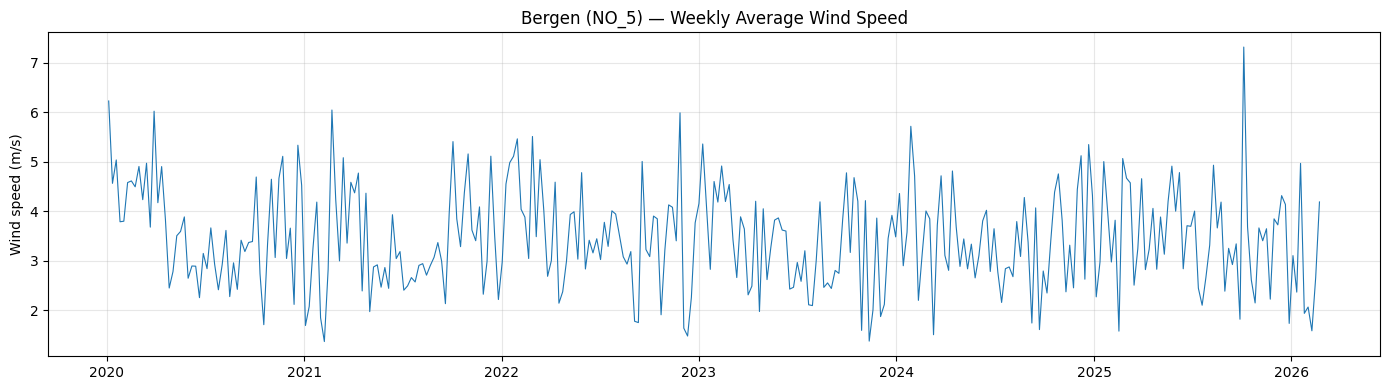

Average wind speed: 3.4 m/s
Windiest: 22.3 m/s
Bergen is one of the windier locations in Norway — good for wind power.


In [8]:
fig, ax = plt.subplots(figsize=(14, 4))

# Weekly average wind speed
weekly_wind = weather["wind_speed"].resample("W").mean()
ax.plot(weekly_wind.index, weekly_wind.values, color="tab:blue", linewidth=0.8)
ax.set_ylabel("Wind speed (m/s)")
ax.set_title("Bergen (NO_5) — Weekly Average Wind Speed")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average wind speed: {weather['wind_speed'].mean():.1f} m/s")
print(f"Windiest: {weather['wind_speed'].max():.1f} m/s")
print("Bergen is one of the windier locations in Norway — good for wind power.")

## Using our build_features module

All of the above is packaged in `build_weather_features()`. Let's verify it produces the same features.

In [9]:
from src.features.build_features import build_weather_features

weather_feats = build_weather_features("NO_5", "2020-01-01", "2026-02-22")

print(f"Shape: {weather_feats.shape}")
print(f"Columns: {list(weather_feats.columns)}")
print(f"Missing values:")
print(weather_feats.isna().sum())
print(f"\nSample:")
weather_feats.head()

Shape: (53712, 5)
Columns: ['temperature', 'wind_speed', 'precipitation', 'temperature_lag_24h', 'temperature_rolling_24h_mean']
Missing values:
temperature                      0
wind_speed                       0
precipitation                    0
temperature_lag_24h             24
temperature_rolling_24h_mean     0
dtype: int64

Sample:


,temperature,wind_speed,precipitation,temperature_lag_24h,temperature_rolling_24h_mean
timestamp,,,,,
2020-01-01 01:00:00+01:00,6.6,4.8,0.2,NaN,6.600000
2020-01-01 02:00:00+01:00,6.8,6.1,0.0,NaN,6.700000
2020-01-01 03:00:00+01:00,6.9,5.8,0.1,NaN,6.766667
2020-01-01 04:00:00+01:00,6.9,4.3,0.0,NaN,6.800000
2020-01-01 05:00:00+01:00,6.9,4.8,0.0,NaN,6.820000


## Key takeaways

1. **Temperature** is the main weather driver — cold = more heating = higher prices
2. **Lag features** (e.g., `temperature_lag_24h`) let the model compare today vs yesterday
3. **Rolling means** smooth out noise and capture the general trend
4. **Wind speed** affects supply (more wind generation = lower prices)
5. **Precipitation** fills reservoirs — important for hydro-dominated Norway
6. Weather data is hourly (same as our target), so no resampling needed

**Concept recap:**
- `shift(N)` = lag feature (value from N hours ago)
- `rolling(N).mean()` = moving average over last N hours
- These are the building blocks for **all** time series feature engineering

**Next notebook:** 03_market_features — commodities, FX, and Statnett supply/demand